In [1]:
from __future__ import division, print_function
import sys
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout,ZeroPadding2D, Dropout,Concatenate,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import Activation, Reshape
from tensorflow.keras.layers import Convolution2D, Conv2D,MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
import time
from sklearn.metrics import confusion_matrix

In [2]:
## PRINT THE TENSORFLOW VERSION
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
#SOME LINKS
#https://keras.io/examples/vision/image_classification_from_scratch/
#https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
#https://stackoverflow.com/questions/66022256/modulenotfounderror-no-module-named-tensorflow-core-estimator-for-tensorflow
#https://www.tensorflow.org/tutorials/keras/regression
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/
#https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

In [3]:
# FUNCTION DEFINITIONS
def make_dir_paths(mypath):
    if not os.path.isdir(mypath):
        os.makedirs(mypath)
        print("created path")
        

## functions for loading the data
def nulltozero(arr):
    arrcopy = np.copy(arr)
    low_values_flags = arrcopy < 0 #0.7,0  
    arrcopy[low_values_flags]=0
    return arrcopy
#functions for loading the images and converting them to arrays

def img_to_array(*images):
    """Convert an image or list of images to numpy arrays.

    Keyword arguments:
    *images -- list containing the images to be converted
    """
    imgarrays = []
    i = 0
    for img in images:
        arr = gtiff_to_array(img)
        imgarrays.append(arr)
    return imgarrays


def gtiff_to_array(imgfname):                                      
    """Transform a geotiff to numpy array.

    Keyword arguments:
    imgfnames -- filename of image to convert
    """
    ds = gdal.Open(imgfname)
    for band in range(ds.RasterCount):
        band += 1
        if band == 1:
            arr = np.array(ds.GetRasterBand(band).ReadAsArray())
            arr = np.expand_dims(arr, axis=2)
        else:
            concat = np.array(ds.GetRasterBand(band).ReadAsArray())
            concat = np.expand_dims(concat, axis=2)
            arr = np.concatenate((arr,
                                  concat),
                                 axis=2)
    return arr

def reclassgts2(gtsarray):
    """Reclassify ground truth dataset array to single class numbers.

    Keyword arguments:
    gtsarray -- the ground truth dataset array
    """
    reclassarray = np.zeros(shape=(gtsarray.shape[0], gtsarray.shape[1]),
                            dtype=np.uint8)
    cnum = 1
    mask = np.logical_or(np.logical_or(gtsarray[:,:,0]==1,gtsarray[:,:,0]==3),gtsarray[:,:,0]==4)
    reclassarray[mask]=cnum

    cnum2 = 2
    mask = np.logical_or(gtsarray[:,:,0]==2,gtsarray[:,:,0]==2)
    reclassarray[mask] = cnum2
    return reclassarray

#create idxarray for the creation of the map

def sample_idx(arr):
    """Randomly sample an array stratified based on frequency.

    Keyword arguments:
    arr -- the array being sampled
    cratios -- the representative fractions of each classes
    n -- total number of samples (default 1000)
    """
    i = 0
    arr_copy = np.copy(arr)
    idxarray = np.zeros(shape=(0, 2), dtype=np.int16)
    nc = np.array(np.where(arr_copy >0)).T.shape[0]
    arr_flat = arr_copy.flatten()
    n = arr_flat.shape[0]
    randidx = np.asarray(range(n),dtype= np.int32)
    #randidx=randidx.astype(np.int32)
    idxarray = np.array(np.where(arr_copy >= 0)).T[randidx, :]
    #sampleidx += csamples

    del arr_copy
    return idxarray

def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

def swap_axes(arr):
    return np.expand_dims(arr, axis = 0)

##attempting to perform classification by loading the entire tiles

#remove nan
def nulltozero_g(arr):
    arrcopy = np.copy(arr)
    low_values_flags = (np.isnan(arr))#0.7,0
    arrcopy[low_values_flags]=0
    return arrcopy

def extract_geometry(path_dir):
    raster_dataset = gdal.Open(path_dir, gdal.GA_ReadOnly)
    geo_transform = raster_dataset.GetGeoTransform()

    return geo_transform


#Reclassifying the array and giving it coordinates
def reclass_gts(gtsarray):
    """Reclassify ground truth dataset array to single class numbers.

    Keyword arguments:
    gtsarray -- the ground truth dataset array
    """
    reclassarray = np.zeros(shape=(gtsarray.shape[0], gtsarray.shape[1]),
                            dtype=np.uint8)
    cnum = 1
    for color in _ccolors:
        mask = np.logical_and(np.logical_and(gtsarray[:, :, 0] == color[0],
                              gtsarray[:, :, 1] == color[1]),
                              gtsarray[:, :, 2] == color[2])
        reclassarray[mask] = cnum
        cnum += 1
    return reclassarray

def save_to_1band(arr,out_path,geom,proj):
    #save a one band image
    #p_rec is the reclassified array and has two dimensions
    #pred_map_GCs2 = predsdir + "trainingset_3/georeferenced/fcn_atr_goma_1947_clip1_1bands.tif"
    arr=np.expand_dims(arr, axis=2)
    nrows,ncols,nbands = arr.shape[0],arr.shape[1],arr.shape[2]
    driver = gdal.GetDriverByName('GTiff')
    nw_ds = driver.Create(out_path, ncols, nrows, nbands, gdal.GDT_Int16 )
    nw_ds.SetGeoTransform(geom)
    nw_ds.SetProjection(proj)

    nw_ds.GetRasterBand(1).WriteArray(arr[:, :,0])

    #for i in range(nbands):
    #	nw_ds.GetRasterBand(i+1).WriteArray(P_rec[:, :, i])

    nw_ds = None

def save_prob_1band(arr,out_path,geom,proj):
    #save a one band image
    #p_rec is the reclassified array and has two dimensions
    #pred_map_GCs2 = predsdir + "trainingset_3/georeferenced/fcn_atr_goma_1947_clip1_1bands.tif"
    arr=np.expand_dims(arr, axis=2)
    nrows,ncols,nbands = arr.shape[0],arr.shape[1],arr.shape[2]
    driver = gdal.GetDriverByName('GTiff')
    nw_ds = driver.Create(out_path, ncols, nrows, nbands, gdal.GDT_Float32 )
    nw_ds.SetGeoTransform(geom)
    nw_ds.SetProjection(proj)

    nw_ds.GetRasterBand(1).WriteArray(arr[:, :,0])

    #for i in range(nbands):
    #	nw_ds.GetRasterBand(i+1).WriteArray(P_rec[:, :, i])

    nw_ds = None

# normalize the top array
def norm_rgbn(data,gmax,gmin):
    """
    rexcale  the multispectral data [0,1]
    data--the multispectral array
    """
    data = data.astype(float)
    data_norm = (data - gmin)/(gmax - gmin)
    return data_norm

def data_proj(arr_path):
    '''
    extract the projections of the data
    '''
    raster_dataset = gdal.Open(arr_path, gdal.GA_ReadOnly)
    geo_transform = raster_dataset.GetGeoTransform()
    proj = raster_dataset.GetProjectionRef()
    return geo_transform,proj

def split_arr(arr,step = 32, window_size =(32,32)):
    '''
    split an image into patches
    '''
    arr_list = []
    #nrow,ncol = arr.shape[0],arr.shape[1]# row,col,nchannels
    for x in range(0,arr.shape[0],step):
        if x + window_size[0]>arr.shape[0]:
            x=arr.shape[0]-window_size[0]
        for y in range(0, arr.shape[1],step):
            if y + window_size[1]> arr.shape[1]:
                y = arr.shape[1] -window_size[1]
            #generate the arrays
            arr_list.append(arr[x:x+step,y:y+step,:])
    #concatenate
    arr_list_to_arr=np.asarray(arr_list)
    #tot_set= np.concatenate(alltrainset_momo, axis=0)
    return arr_list_to_arr

# pad
#rgbn_norm.shape (906, 898, 1)
#how to calculate the pad_row,pad_col
def pad_zeros(arr,pad_row,pad_col):
    '''
    Zero padding to an input array
    '''
    nrow,ncol,nband = arr.shape[0],arr.shape[1],arr.shape[2]
    nw_arr = np.zeros((nrow+pad_row,ncol+pad_col,nband),dtype = arr.dtype)
    nw_arr[:nrow,:ncol,] = arr[:,:,:]
    return nw_arr

def pad_size(arr,psize):
    '''
    calculate the padding size for rows and colums
    '''
    if arr.shape[0]%psize!=0:
        pad_row = (arr.shape[0]//psize+1)*psize - arr.shape[0]
    else:
        pad_row = 0
    if arr.shape[1]%psize!=0:
        pad_col = (arr.shape[1]//psize+1)*psize - arr.shape[1]
    else:
        pad_col = 0
    return pad_row,pad_col

In [8]:
root_path = "E:/DEPAI_project"

In [5]:
#curated data
"adding path to the gray images dataset"
#smpldir="E:/DEPAI_project/trial_arrays/train/city_samples.hdf5"
smpldir=root_path +"/trial_arrays/train/city_samples.hdf5"
#reading the training data

with h5py.File(smpldir, "r") as f:
    x_train = np.asarray(f["X_train"]) 
    y_train = np.asarray(f["Y_train"])


In [6]:
%%time

# YOU CAN CHANGE THE PARAMETERS OF THE MODEL

def PATCH_CNN(psize, nb, pretrained_weights = None):
    '''
    psize-- patch size
    nb-- number of input channels
    
    
    '''
    input_tensor = Input(shape=(psize, psize,nb))
    
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(input_tensor)
    conv1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    flat1 = Flatten()(pool2)
    
    fc1   = Dense(64)(flat1)
    #drop1 = Dropout(0.5)(fc1)
    
    fc2   = Dense(8)(fc1)
    #drop2 = Dropout(0.5)(fc2)
    
    #add the last dense layer
    
    fc3 = Dense (1)(fc2)
  
    out   = Activation("sigmoid")(fc3)
    
    model = Model(inputs = input_tensor, outputs = out)
    
    

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


#INITIALISE THE MODEL
dep_model = PATCH_CNN(10,4)


dep_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics = ['accuracy'],
                 optimizer = tf.keras.optimizers.Adam(0.001))

# YOU CAN SLICE THE DATA ARRAY TO REFLECT THE CHOICE OF SENTINEL BANDS
#EG 1:5 SELECTS BAND 2- BAND 5 since the aerosol band in sentinel image is not used
#https://gisgeography.com/sentinel-2-bands-combinations/
history = dep_model.fit(
    x_train[:,:,:,1:5],
    y_train,
    epochs=20,
    batch_size = 64,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Train on 484 samples, validate on 122 samples
Epoch 1/20
484/484 [==============================] - 2s 4ms/sample - loss: 432.5568 - accuracy: 0.5248 - val_loss: 228.7717 - val_accuracy: 0.5656
Epoch 2/20
484/484 [==============================] - 0s 554us/sample - loss: 134.6068 - accuracy: 0.5289 - val_loss: 121.8380 - val_accuracy: 0.4590
Epoch 3/20
484/484 [==============================] - 0s 595us/sample - loss: 53.9257 - accuracy: 0.5806 - val_loss: 80.3962 - val_accuracy: 0.4344
Epoch 4/20
484/484 [==============================] - 0s 593us/sample - loss: 34.2543 - accuracy: 0.6116 - val_loss: 82.3017 - val_accuracy: 0.4344
Epoch 5/20
484/484 [==============================] - 0s 536us/sample - loss: 29.3324 - accuracy: 0.6219 - val_loss: 53.0782 - val_accuracy: 0.5492
Epoch 6/20
484/484 [==============================] - 0s 610us/sample - loss: 30.0638 - accuracy: 0.6033 - val_loss: 63.1221 - val_accuracy: 0.4262
Epoch 7/20
484/484 [==============================] - 0s 587us/s

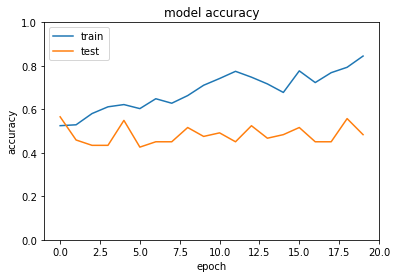

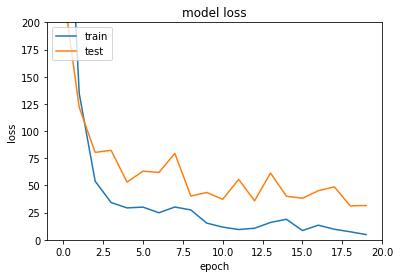

In [9]:
#PLOT THE LOSS AND ACCURACY CURVES DURINT TRAINING 

#dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
logs_folder = root_path + "/logs/"
nb_epochs = 20
#summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel ('accuracy')
plt.xlabel('epoch')
plt.axis([-1,nb_epochs,0,1])
plt.legend(['train','test'], loc = 'upper left')
plt.savefig(logs_folder+"/model_accuracy.png")

#visualise and close the figure
plt.show()


#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([-1,nb_epochs,0.0,200])
plt.legend(['train','test'], loc='upper left')
plt.savefig(logs_folder+"/model_loss.png")

#visualise and close the figure
plt.show()


In [83]:
# SAVE THE MODEL WEIGHTS
# can be loaded for future experiments
root_path = 'E:/DEPAI_project'
dep_model.save(root_path + '/weights/dnn_model.h5')

#load the weights
#dep_model.load_weights(w8_fname)

#or
#loaded_model = tf.keras.models.load_model(root_folder + '/weights/dnn_model.h5')
#dep_model = loaded_model

# NICE TUTORIAL
#https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model
# https://www.youtube.com/watch?v=7n1SpeudvAE&ab_channel=deeplizard

In [ ]:
# RUN THIS SECTION IF YOU HAVE THE TEST DATA IN A SEPARATE FOLDER
# load the test data

"adding path to the gray images dataset"
smpldir="E:/DEPAI_project/trial_arrays/test/city_samples.hdf5"

#reading the training data

with h5py.File(smpldir, "r") as f:
    x_test = np.asarray(f["X_test"]) 
    y_test = np.asarray(f["Y_test"])
    
#evaluate model
loss, acc = dep_model.evaluate(x_test[:,:,:,1:5], y_test, verbose=0)
print('Accuracy: %.3f' % acc)
print('Loss: %.3f' % loss)

In [48]:
#GENERATE A CLASSIFIED MAP OF PROBABILITIES FROM YOUR TEST TILE

In [49]:
in_file = root_path+"/raw_tif_totrain/subset_S2_mosaic_2019Q1.tif"
# make_dir_paths(in_file)

rgbn_raw=img_to_array(in_file)
geo_info,projec_info=data_proj(in_file)

#normalize the rgb
#rgbn_norm=norm_rgbn(rgbn_raw[0],gmax,gmin)
rgbn_norm = rgbn_raw[0]

pad_row,pad_col = pad_size(rgbn_norm,10)

#Add zero padding 
padded_arr = pad_zeros(rgbn_norm,pad_row,pad_col)

# split patches
split_patches = split_arr(padded_arr, step =10,  window_size =(10,10))


In [78]:
#GENERATE PREDICTIONS ON THE TEST TILE
preds = dep_model.predict(split_patches[:,:,:,1:5].astype('float'))
preds_reshaped = np.reshape(preds,(int(padded_arr.shape[0]/10),int(padded_arr.shape[1]/10)))

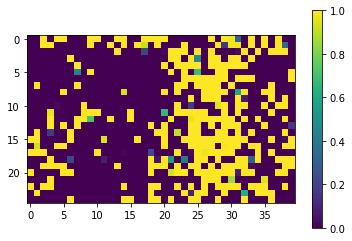

In [80]:
#plot the predictions
plt.imshow(preds_reshaped)
plt.colorbar()
# There is an extra padding that needs to be removed.
# we can remove it easily during saving through slicing

plt.show()

In [87]:
# save file of prob map
# edit the geo_information to reflect the new patch size
geo_info1 = (geo_info[0],100,geo_info[2],geo_info[3],geo_info[4],-100)

out_path = root_path +"/predicted_map/tile_2.tif"

save_prob_1band(preds_reshaped,out_path,geo_info1,projec_info)